In [1]:
import numpy as np
import matplotlib.ticker as ticker

from utils import *

# Flexibility Market

In [2]:
# Define the parameter lists
cong_rebate = [1, 3, 5] # rebate in $/kWh - e.g. 5
baseline_lookbacks = [3, 5, 10]
num_cong_weekdays_list = [1, 2, 3]

# Define possible congestion weekdays based on the number of days
cong_weekdays_options = {
    1: [0],          # Monday
    2: [0, 3],       # Monday and Thursday
    3: [0, 3, 5]     # Monday, Thursday, and Saturday
}
cong_hours = [10, 11, 12]  # Keeping congestion hours constant

start_date = '2023-01-01'  # Start Date for data
end_date = '2023-12-31'    # End Date for data
num_ems = 1  # Number of different EMS Units to generate data for
chunk_size_days = 40 # Number of days to iterativly solve the BESS MIP

# Define parameters for BESS and Flexibility
bess_params = {
    'soc_init': 0,
    'soc_min': 0,
    'soc_max': 10,
    'eta': 0.98,
    's_max': 5,
    'bound': 100,
}

# Loop over the different parameters
for cong_rebate in cong_rebate:
    for baseline_lookback in baseline_lookbacks:
        for num_cong_weekdays in num_cong_weekdays_list:

            # Set the current parameters
            max_lookback = int(baseline_lookback*2)
            cong_weekdays = cong_weekdays_options[num_cong_weekdays]

            # Initialize an empty DataFrame to hold all results
            all_results = pd.DataFrame()
            for ems_id in range(1, num_ems + 1):

                random_seed = ems_id * 10

                # Print current configuration
                print(f"EMS_ID {ems_id}, Cong_Rebate {cong_rebate}, Baseline Lookback {baseline_lookback}, Cong Weekdays {cong_weekdays}")

                # CONGESTION
                # Generate data (Load, PV, Price)
                ems_data_cong = generate_ems_data(ems_id, start_date, end_date, cong_rebate, cong_weekdays, cong_hours, random_seed)
                # Generate BESS charging and Net consumption Data using MIP
                ems_results_cong = solve_optimization_iterativly(ems_data_cong, bess_params, baseline_lookback, chunk_size_days, max_lookback)
                # Append congestion results to all_results DataFrame
                ems_results_cong['Scenario'] = 'Cong'
                all_results = pd.concat([all_results, ems_results_cong], ignore_index=True)
            
                # ----------------------------------------------------------------------

                # NO CONGESTION
                # Generate data (Load, PV, Price)
                ems_data_no_cong = generate_ems_data(ems_id, start_date, end_date, cong_rebate, cong_weekdays=[], cong_hours=[], random_seed=random_seed)
                # Generate BESS charging and Net consumption Data using MIP
                ems_results_no_cong = solve_optimization_iterativly(ems_data_no_cong, bess_params, baseline_lookback, chunk_size_days, max_lookback)

                # Append no congestion results to all_results DataFrame
                ems_results_no_cong['Scenario'] = 'NoCong'
                all_results = pd.concat([all_results, ems_results_no_cong], ignore_index=True)

                # Save combined results to a single CSV file
                cong_days_str = '_'.join(map(str, cong_weekdays))
                cong_hours_str = '_'.join(map(str, cong_hours))
                final_filename = f"../../data/bess_results/Results_Rebate{cong_rebate}_Baseline{baseline_lookback}_CongDays{cong_days_str}_Hours{cong_hours_str}.csv"
                all_results.to_csv(final_filename, index=False)               


EMS_ID 1, Cong_Rebate 1, Baseline Lookback 3, Cong Weekdays [0]
Set parameter Username
Set parameter LicenseID to value 2593432
Academic license - for non-commercial use only - expires 2025-11-30
Optimal solution found for 2023-01-01 to 2023-02-10.
Optimal solution found for 2023-02-04 to 2023-03-16.
Optimal solution found for 2023-03-10 to 2023-04-19.
Optimal solution found for 2023-04-13 to 2023-05-23.
Optimal solution found for 2023-05-17 to 2023-06-26.
Optimal solution found for 2023-06-20 to 2023-07-30.
Optimal solution found for 2023-07-24 to 2023-09-02.
Optimal solution found for 2023-08-27 to 2023-10-06.
Optimal solution found for 2023-09-30 to 2023-11-09.
Optimal solution found for 2023-11-03 to 2023-12-13.
Optimal solution found for 2023-01-01 to 2023-02-10.
Optimal solution found for 2023-02-04 to 2023-03-16.
Optimal solution found for 2023-03-10 to 2023-04-19.
Optimal solution found for 2023-04-13 to 2023-05-23.
Optimal solution found for 2023-05-17 to 2023-06-26.
Optimal s

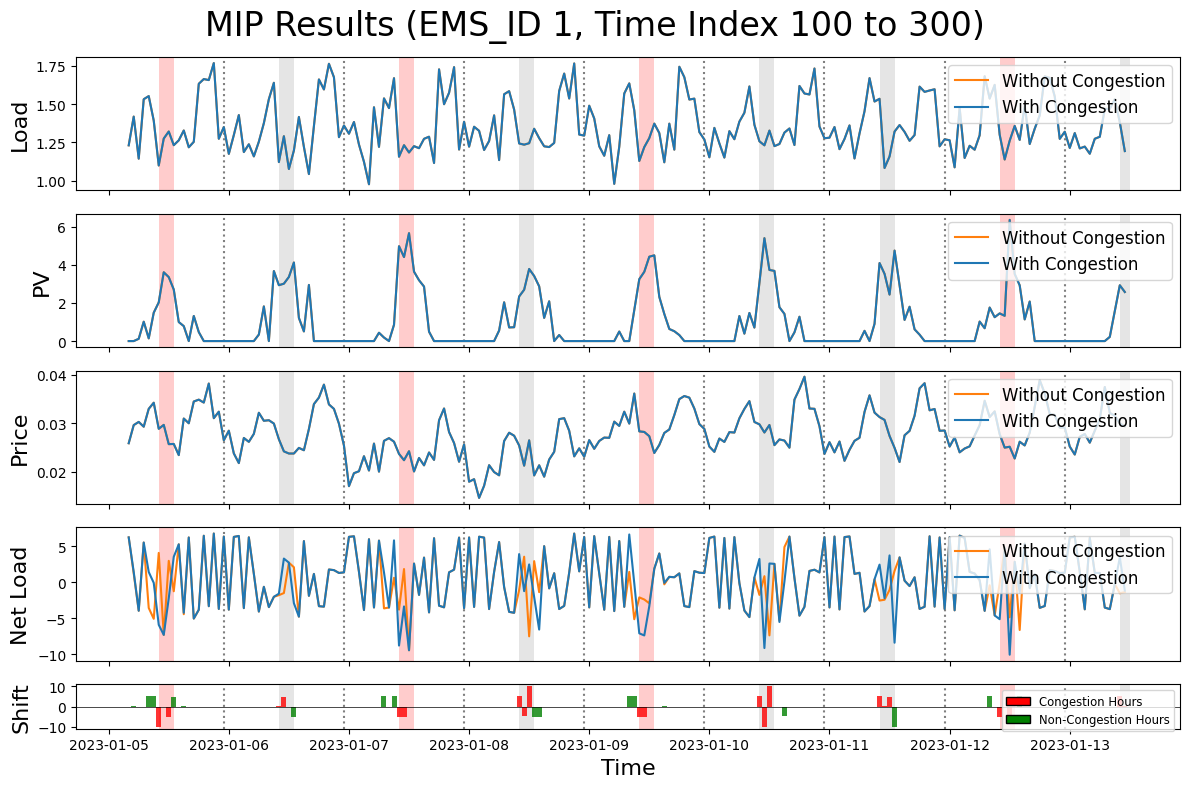

In [ ]:
def compare_results(cong_data, nocong_data, start_idx, end_idx, save=False):
    """
    Plot and compare results from two dataframes for a specific EMS_ID within a specified window.
    
    Parameters:
    - result_cong: DataFrame with congestion results
    - result_Nocong: DataFrame without congestion results
    - ems_id: The EMS_ID to filter and plot
    - start_idx: Starting index for the plot window (default 0)
    - end_idx: Ending index for the plot window (default None, which means until the end)
    """   
    ems_id = cong_data["EMS_ID"][0]
    # Convert Time to datetime if it's not already
    cong_data['Time'] = pd.to_datetime(cong_data['Time'])
    nocong_data['Time'] = pd.to_datetime(nocong_data['Time'])
    
    # Apply the window
    cong_data = cong_data.iloc[start_idx:end_idx]
    nocong_data = nocong_data.iloc[start_idx:end_idx]
    
    # Create subplots
    fig, axs = plt.subplots(5, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 3, 3, 3, 1]}, sharex=True)
    fig.suptitle(f'MIP Results (EMS_ID {ems_id}, Time Index {start_idx} to {end_idx if end_idx else "End"})', fontsize=24)

    # Define colors for the lines
    color_with_cong = '#1f77b4'  # Blue
    color_without_cong = '#ff7f0e'  # Orange

    # Highlight congestion intervals and potential congestion hours
    for ax in axs:
        for _, row in cong_data.iterrows():
            time = row['Time']
            if row['Congestion'] == 1:
                # Red background for congestion days
                ax.axvspan(time, time + pd.Timedelta(hours=1), facecolor='red', alpha=0.2)
            else:
                # Grey background for potential congestion hours (10, 11, 12) on non-congestion days
                if time.hour in [10, 11, 12]:
                    ax.axvspan(time, time + pd.Timedelta(hours=1), facecolor='grey', alpha=0.2)
        
        # Add dotted lines for day endings
        day_ends = cong_data[cong_data['Time'].dt.hour == 23]['Time']
        for day_end in day_ends:
            ax.axvline(day_end, color='black', linestyle=':', alpha=0.5)


    # Plot Load
    axs[0].plot(nocong_data['Time'], nocong_data['Load'], label='Without Congestion', color=color_without_cong)
    axs[0].plot(cong_data['Time'], cong_data['Load'], label='With Congestion', color=color_with_cong)
    axs[0].set_ylabel('Load', fontsize=16)
    axs[0].legend(loc='upper right', fontsize=12)
    
    # Plot PV Generation
    axs[1].plot(nocong_data['Time'], nocong_data['PV_Generation'], label='Without Congestion', color=color_without_cong)
    axs[1].plot(cong_data['Time'], cong_data['PV_Generation'], label='With Congestion', color=color_with_cong)
    axs[1].set_ylabel('PV', fontsize=16)
    axs[1].legend(loc='upper right', fontsize=12)
    
    # Plot Price
    axs[2].plot(nocong_data['Time'], nocong_data['Price'], label='Without Congestion', color=color_without_cong)
    axs[2].plot(cong_data['Time'], cong_data['Price'], label='With Congestion', color=color_with_cong)
    axs[2].set_ylabel('Price', fontsize=16)
    axs[2].legend(loc='upper right', fontsize=12)
    
    # Plot Net Consumption
    axs[3].plot(nocong_data['Time'], nocong_data['NetConsumption_Optimized'], label='Without Congestion', color=color_without_cong)
    axs[3].plot(cong_data['Time'], cong_data['NetConsumption_Optimized'], label='With Congestion', color=color_with_cong)
    axs[3].set_ylabel('Net Load', fontsize=16)
    axs[3].legend(loc='upper right', fontsize=12)
    
    # Plot Net Consumption Difference in a separate small subplot
    diff = cong_data['NetConsumption_Optimized'] - nocong_data['NetConsumption_Optimized']
    bar_width = pd.Timedelta(hours=1)

    congestion_color = 'red'
    non_congestion_color = 'green'
    bar_colors = [congestion_color if time.hour in [10, 11, 12] else non_congestion_color for time in cong_data['Time']]
    
    axs[4].bar(cong_data['Time'], diff, width=bar_width.total_seconds() / 3600 / 24, alpha=0.8, color=bar_colors)
    axs[4].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axs[4].set_ylabel('Shift', fontsize=16)

    # Add a legend for the bar colors
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=congestion_color, edgecolor='black', label='Congestion Hours'),
                       Patch(facecolor=non_congestion_color, edgecolor='black', label='Non-Congestion Hours')]
    axs[4].legend(handles=legend_elements, loc='upper right', fontsize='small')
    
    # Set x-axis label for the bottom subplot
    axs[4].set_xlabel('Time', fontsize=16)
    
    
    # Adjust layout and display plot
    plt.tight_layout()
    if save:
        plt.savefig(f'figures/MIP Results_EMS_ID {ems_id}_Time Index {start_idx} to {end_idx if end_idx else "End"}).pdf', format='pdf', dpi=300)
    plt.show()

result = pd.read_csv("../../data/bess_results/Run1/Results_Rebate1_Baseline3_CongDays0_3_5_Hours10_11_12.csv")
result_cong = result[result["Scenario"]=="Cong"].reset_index(drop=True)
result_nocong = result[result["Scenario"]=="NoCong"].reset_index(drop=True)
start_idx=100
end_idx=start_idx+200
compare_results(result_cong, result_nocong, start_idx, end_idx, save=False)